In [8]:
import gc
import sys
from statistics import mean
import time
import torch
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import itertools
from pathlib import Path
from scipy import special
import matplotlib.pyplot as plt
import datetime
import torch.linalg as LA
from torch.distributions.laplace import Laplace



import utils
import models
import learning_utils
from configurations import args_parser, arguments

%load_ext autoreload
%autoreload 2


args = arguments()
num_users = 30
num_users_per_round = 5


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
local_models = {}

class user():
    def __init__(self, ucb, g, p,args):
        self.ucb = ucb
        self.g = g
        self.privacy_reward = p
        self.args = args
        self.user_idx = None

#create an array with 30 rows and 3 columns where each column is a permutation of 1,...,30
base_arange = np.arange(num_users)/10
base_array = np.concatenate([np.random.permutation(base_arange).reshape(-1,1) for i in range(3)], axis=1)

for row in range(base_array.shape[0]):
    #create a user object with the ucb, g, and p values
    u = user(base_array[row,0], base_array[row,1], base_array[row,2], args)
    u.user_idx = row
    local_models[row] = u


users_idxs_comb = list(itertools.combinations([x for x in range(num_users)], num_users_per_round))
# permute the users_idxs_comb to make the order of the users random
np.random.shuffle(users_idxs_comb)
winning_comb = None
best_score = 0
for comb in users_idxs_comb:
    score = utils.compute_energy(comb, local_models, args)
    if score > best_score:
        best_score = score
        winning_comb = comb

print(winning_comb)
print(best_score)


energy_list, _, best_score = utils.choose_users(local_models, args, global_epoch=1, textio=None
                                                ,method="ALSA",  num_users = num_users, num_users_per_round = num_users_per_round)

(4, 6, 13, 17, 25)
276.4
ALSA took 0.0 minutes and 0.3323242664337158 seconds to run


Best score:  276.3999997079259


C:\Users\oripele\AppData\Local\Temp\ipykernel_15024\3559421177.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot([best_score]*len(energy_list), 'r--', color="orange")


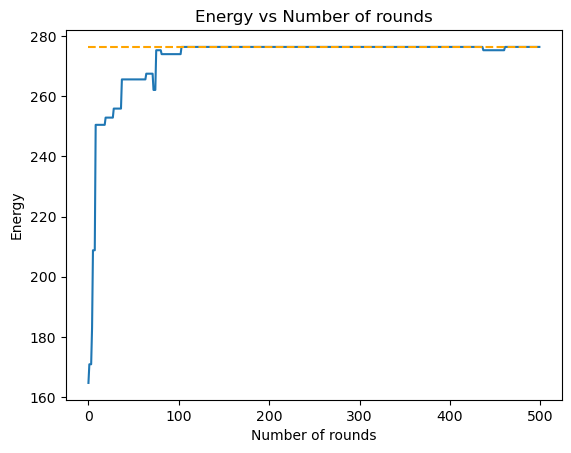

In [10]:
fig, ax = plt.subplots()

ax.plot(energy_list)
ax.plot([best_score]*len(energy_list), 'r--', color="orange")
ax.set(xlabel='Number of rounds', ylabel='Energy',
       title='Energy vs Number of rounds')

print("Best score: ", best_score)